## Import library

In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchmetrics

import numpy as np
import pandas as pd

import albumentations
import albumentations.pytorch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm

## Download dataset

In [2]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('sorour/38cloud-cloud-segmentation-in-satellite-images', path='dataset', unzip=True)

## Configurations

In [3]:
!nvidia-smi

Thu Dec  1 18:19:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
| 40%   41C    P2    63W / 260W |    909MiB / 11019MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
| 41%   

In [4]:
BASE_DIR = 'dataset'
TRAIN_DIR = f'{BASE_DIR}/38-Cloud_training'
TEST_DIR = f'{BASE_DIR}/38-Cloud_test'
TRAIN_PATCHES_FILE = f'{BASE_DIR}/training_patches_38-cloud_nonempty.csv'
TEST_PATCHES_FILE = f'{TEST_DIR}/test_patches_38-Cloud.csv'
BATCH_SIZE = 12
NUM_EPOCHS = 20
LOW_TRAINABLE_THRESHOLD = 0.03
HIGH_TRAINABLE_THRESHOLD = 0.97
LEARNING_RATE = 1e-4

torch.manual_seed(42)
torch.cuda.is_available()

True

In [5]:
torch.cuda.set_device(7)
print(torch.cuda.current_device())

7


## Import Dataset

In [6]:
class CreateCloudDataset():
    def __init__(self):
        self.transform = albumentations.Compose([
            albumentations.Normalize(mean=[0.0], std=[1.0], max_pixel_value=65535.0),
            albumentations.Resize(192, 192),
            albumentations.pytorch.ToTensorV2()
        ])
        self.train_patches = pd.read_csv(TRAIN_PATCHES_FILE)
        self.test_patches = pd.read_csv(TEST_PATCHES_FILE)

    def import_dataset(self, patches, is_train):
        if is_train:
            bands = ['nir', 'red', 'green', 'blue', 'gt']
            bands_path = [f"{TRAIN_DIR}/train_{x}/{x}_" for x in bands]
        else:
            bands = ['nir', 'red', 'green', 'blue']
            bands_path = [f"{TEST_DIR}/test_{x}/{x}_" for x in bands]
            
        dataset = []
        ratio_non_zero_map = {}
        

        for i in tqdm(range(len(patches))):
            image_file_name = patches.iloc[i][0]
            bands_file_name = [f"{x}{image_file_name}.TIF" for x in bands_path]
            all_bands = []
            for x in bands_file_name:
                im = Image.open(x)
                image = np.array(im, dtype=np.float32)
                im.close()
                all_bands.append(self.transform(image=image)['image'])
            non_zero = torch.count_nonzero(all_bands[-1])
            ratio_non_zero = non_zero.item()/(192*192)
            
            rounded_ratio_non_zero = round(ratio_non_zero, 1)
            if rounded_ratio_non_zero not in ratio_non_zero_map:
                ratio_non_zero_map[rounded_ratio_non_zero] = 1
            else:
                ratio_non_zero_map[rounded_ratio_non_zero] += 1
            
            if ratio_non_zero < LOW_TRAINABLE_THRESHOLD or ratio_non_zero > HIGH_TRAINABLE_THRESHOLD:
                continue
            image = torch.cat((all_bands[0], all_bands[1], all_bands[2], all_bands[3]), dim=0)
            if is_train:
                label = all_bands[-1]
                label[label > 0] = 1.0
                dataset.append((image, label))
            else:
                dataset.append((image, image_file_name)) 
                
        ratio_non_zero_key = list(ratio_non_zero_map.keys())
        ratio_non_zero_val = list(ratio_non_zero_map.values())
        plt.bar(range(len(ratio_non_zero_map)), ratio_non_zero_val, tick_label=ratio_non_zero_key)
        plt.show()
        return dataset

class CloudTrainDataset():
    def __init__(self, dataset):
            self.dataset = dataset
            self.train_dataset, self.valid_dataset = self.split(train_ratio=0.8)
            self.train_dataset = self.create_batch(self.train_dataset, BATCH_SIZE, shuffle=True)
            self.valid_dataset = self.create_batch(self.valid_dataset, BATCH_SIZE, shuffle=False)
    
    def split(self, train_ratio):
            train_size = int(train_ratio * len(self.dataset))
            valid_size = len(self.dataset) - train_size
            return random_split(self.dataset, [train_size, valid_size])

    def create_batch(self, data, batch_size, shuffle):
            return DataLoader(data, batch_size=batch_size, shuffle=shuffle)
        
class CloudTestDataset():
    def __init__(self, dataset):
            self.dataset = dataset
            self.test_dataset = self.create_batch(self.test_dataset, BATCH_SIZE, shuffle=False)

    def create_batch(self, data, batch_size, shuffle):
            return DataLoader(data, batch_size=batch_size, shuffle=shuffle)  

100%|███████████████████████████████████████████████████████████████████████████████| 5155/5155 [02:38<00:00, 32.61it/s]


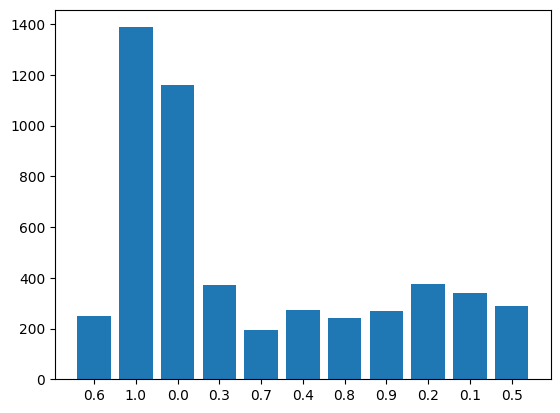

In [7]:
ds = CreateCloudDataset()
train_dataset = ds.import_dataset(ds.train_patches, is_train=True)

In [8]:
len(train_dataset)

2788

In [9]:
dataset = CloudTrainDataset(train_dataset)

## Preview Dataset

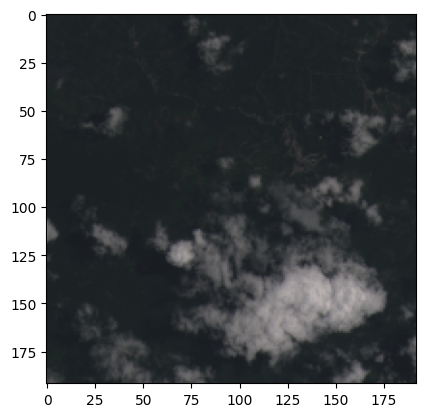

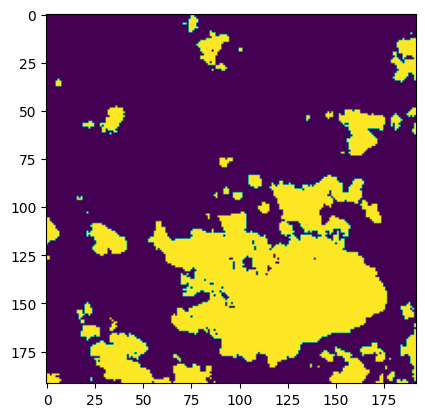

In [10]:
for img, label in dataset.train_dataset:
    img = img[0]
    label = label[0]
    img = np.dstack((img[1], img[2], img[3]))
    label = label.swapaxes(0,1).swapaxes(1,2)
    plt.imshow(img)
    plt.show()
    plt.imshow(label)
    plt.show()
    break

## Define Metrics

In [11]:
class Metrics():
    def __init__(self):
        self.loss = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0
        self.accuracy = 0.0
        self.iou = 0.0
        
    def avg_compute_fn(self, previous_metric_value, added_value, length):
        return (previous_metric_value * length + added_value) / (length+1)

    def compute_loss(self, loss, idx):
        self.loss = self.avg_compute_fn(self.loss, loss, idx)

    def compute_metrics(self, y_pred, y_true, idx):
        self.precision  = self.avg_compute_fn(self.precision, torchmetrics.functional.classification.binary_precision(y_pred, y_true).item(), idx)
        self.recall     = self.avg_compute_fn(self.recall, torchmetrics.functional.classification.binary_recall(y_pred, y_true).item(), idx)
        self.f1         = self.avg_compute_fn(self.f1, torchmetrics.functional.classification.binary_f1_score(y_pred, y_true).item(), idx)
        self.accuracy   = self.avg_compute_fn(self.accuracy, torchmetrics.functional.classification.binary_accuracy(y_pred, y_true).item(), idx)
        self.iou        = self.avg_compute_fn(self.iou, torchmetrics.functional.classification.binary_jaccard_index(y_pred, y_true).item(), idx)

    def print(self, type):
        print(f"[{type}] Loss: {self.loss:.4f},"
            f"   Precision: {self.precision:.4f},"
            f"   Recall: {self.recall:.4f},"
            f"   F1: {self.f1:.4f},"
            f"   Accuracy: {self.accuracy:.4f}," 
            f"   IoU: {self.iou:.4f}")

## Build Model

In [12]:
def fit(model, train_data, valid_data, loss_fn, optimizer):
    best_iou = 0.0
    best_metric = None
    for epoch in range(NUM_EPOCHS):
        loop = tqdm(train_data)
        metrics = Metrics()
        model.train()
        
        for idx, (images, labels) in enumerate(loop):
            images = images.cuda()
            labels = labels.cuda()
            predict = model(images)
            loss = loss_fn(predict, labels)
            metrics.compute_loss(loss.item(), idx)
            metrics.compute_metrics(predict, labels.int(), idx)
            loop.set_postfix(loss=metrics.loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"[Epoch] {epoch}")
        metrics.print("Train")

        with torch.no_grad():
            metrics = Metrics()
            model.eval()
            for idx, (images, labels) in enumerate(valid_data):
                images = images.cuda()
                labels = labels.cuda()
                predict = model(images)
                loss = loss_fn(predict, labels)
                metrics.compute_loss(loss.item(), idx)
                metrics.compute_metrics(predict, labels.int(), idx)
            metrics.print("Valid")
            
            if metrics.iou > best_iou:
                best_iou = metrics.iou
                best_metric = metrics
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_fn,
                    }, 'checkpoint_unet.pt')
    return metrics

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.transposed = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv = DoubleConv(in_channels, out_channels)
        
        self.bn_relu = nn.Sequential(
            nn.BatchNorm2d(out_channels*2),
            nn.ReLU()
        )
        
    def forward(self, skip_connect, x):
        x = self.transposed(x)
        
        if x.shape != skip_connect.shape:
            x = TF.resize(x, size=skip_connect.shape[2:])
        x = torch.cat([skip_connect, x], dim=1)
        x = self.bn_relu(x)
        x = self.conv(x)
        return x
            

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList([
            DoubleConv(in_channels, 64),
            DoubleConv(64, 128),
            DoubleConv(128, 256),
            DoubleConv(256, 512),
        ])
        self.bottle_neck = DoubleConv(512, 1024)
        
        self.ups = nn.ModuleList([
            UpBlock(1024, 512),
            UpBlock(512, 256),
            UpBlock(256, 128),
            UpBlock(128, 64),
        ])

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.final_conv = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1,stride=1,padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        skip_layer = []
        
        for idx, down_layer in enumerate(self.downs):
            x = down_layer(x)
            skip_layer.append(x)
            x = self.pool(x)
            
        x = self.bottle_neck(x)
        
        skip_layer = skip_layer[::-1]
        for idx, up_layer in enumerate(self.ups):
            skip = skip_layer[idx]
            x = up_layer(skip, x)
            
        x = self.final_conv(x)
        return x     

## Train Model

In [14]:
model = UNET(in_channels=4, out_channels=1)
model = nn.DataParallel(model, device_ids = [7, 1])
model.cuda()
loss_fn = nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
best = fit(model, dataset.train_dataset, dataset.valid_dataset, loss_fn, optimizer)

100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:46<00:00,  3.96it/s, loss=0.377]


[Epoch] 0
[Train] Loss: 0.3769,   Precision: 0.8172,   Recall: 0.8460,   F1: 0.8255,   Accuracy: 0.8375,   IoU: 0.7075
[Valid] Loss: 0.2834,   Precision: 0.9147,   Recall: 0.8045,   F1: 0.8536,   Accuracy: 0.8802,   IoU: 0.7481


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.84it/s, loss=0.306]


[Epoch] 1
[Train] Loss: 0.3062,   Precision: 0.8584,   Recall: 0.8735,   F1: 0.8620,   Accuracy: 0.8738,   IoU: 0.7603
[Valid] Loss: 0.3267,   Precision: 0.9404,   Recall: 0.7277,   F1: 0.8181,   Accuracy: 0.8600,   IoU: 0.6956


100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.87it/s, loss=0.28]


[Epoch] 2
[Train] Loss: 0.2800,   Precision: 0.8698,   Recall: 0.8906,   F1: 0.8761,   Accuracy: 0.8868,   IoU: 0.7826
[Valid] Loss: 0.2350,   Precision: 0.9091,   Recall: 0.8805,   F1: 0.8929,   Accuracy: 0.9087,   IoU: 0.8085


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.84it/s, loss=0.257]


[Epoch] 3
[Train] Loss: 0.2569,   Precision: 0.8853,   Recall: 0.8942,   F1: 0.8871,   Accuracy: 0.8976,   IoU: 0.7997
[Valid] Loss: 0.2343,   Precision: 0.8799,   Recall: 0.9026,   F1: 0.8893,   Accuracy: 0.9027,   IoU: 0.8039


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:37<00:00,  4.90it/s, loss=0.241]


[Epoch] 4
[Train] Loss: 0.2406,   Precision: 0.8908,   Recall: 0.9007,   F1: 0.8935,   Accuracy: 0.9030,   IoU: 0.8098
[Valid] Loss: 0.2251,   Precision: 0.8529,   Recall: 0.9365,   F1: 0.8910,   Accuracy: 0.9015,   IoU: 0.8063


100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.85it/s, loss=0.24]


[Epoch] 5
[Train] Loss: 0.2399,   Precision: 0.8920,   Recall: 0.9021,   F1: 0.8946,   Accuracy: 0.9043,   IoU: 0.8115
[Valid] Loss: 0.2497,   Precision: 0.8917,   Recall: 0.8596,   F1: 0.8731,   Accuracy: 0.8914,   IoU: 0.7788


100%|██████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.82it/s, loss=0.23]


[Epoch] 6
[Train] Loss: 0.2303,   Precision: 0.8922,   Recall: 0.9059,   F1: 0.8963,   Accuracy: 0.9057,   IoU: 0.8143
[Valid] Loss: 0.1965,   Precision: 0.8977,   Recall: 0.9225,   F1: 0.9086,   Accuracy: 0.9201,   IoU: 0.8344


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:37<00:00,  4.95it/s, loss=0.218]


[Epoch] 7
[Train] Loss: 0.2177,   Precision: 0.9035,   Recall: 0.9061,   F1: 0.9032,   Accuracy: 0.9124,   IoU: 0.8257
[Valid] Loss: 0.1955,   Precision: 0.9236,   Recall: 0.9038,   F1: 0.9124,   Accuracy: 0.9249,   IoU: 0.8404


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.86it/s, loss=0.212]


[Epoch] 8
[Train] Loss: 0.2117,   Precision: 0.9050,   Recall: 0.9080,   F1: 0.9045,   Accuracy: 0.9141,   IoU: 0.8276
[Valid] Loss: 0.1872,   Precision: 0.9213,   Recall: 0.9110,   F1: 0.9150,   Accuracy: 0.9269,   IoU: 0.8448


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:37<00:00,  4.90it/s, loss=0.212]


[Epoch] 9
[Train] Loss: 0.2123,   Precision: 0.9057,   Recall: 0.9058,   F1: 0.9038,   Accuracy: 0.9132,   IoU: 0.8265
[Valid] Loss: 0.2133,   Precision: 0.8748,   Recall: 0.9405,   F1: 0.9048,   Accuracy: 0.9142,   IoU: 0.8283


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.74it/s, loss=0.203]


[Epoch] 10
[Train] Loss: 0.2034,   Precision: 0.9082,   Recall: 0.9114,   F1: 0.9079,   Accuracy: 0.9171,   IoU: 0.8332
[Valid] Loss: 0.1835,   Precision: 0.8944,   Recall: 0.9362,   F1: 0.9132,   Accuracy: 0.9228,   IoU: 0.8422


100%|███████████████████████████████████████████████████████████████████████| 186/186 [00:37<00:00,  4.92it/s, loss=0.2]


[Epoch] 11
[Train] Loss: 0.2000,   Precision: 0.9120,   Recall: 0.9113,   F1: 0.9098,   Accuracy: 0.9188,   IoU: 0.8364
[Valid] Loss: 0.2015,   Precision: 0.9383,   Recall: 0.8754,   F1: 0.9045,   Accuracy: 0.9196,   IoU: 0.8272


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.87it/s, loss=0.198]


[Epoch] 12
[Train] Loss: 0.1979,   Precision: 0.9133,   Recall: 0.9094,   F1: 0.9097,   Accuracy: 0.9191,   IoU: 0.8361
[Valid] Loss: 0.1809,   Precision: 0.9282,   Recall: 0.9007,   F1: 0.9128,   Accuracy: 0.9254,   IoU: 0.8413


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.88it/s, loss=0.189]


[Epoch] 13
[Train] Loss: 0.1894,   Precision: 0.9170,   Recall: 0.9143,   F1: 0.9143,   Accuracy: 0.9223,   IoU: 0.8437
[Valid] Loss: 0.1839,   Precision: 0.8996,   Recall: 0.9275,   F1: 0.9123,   Accuracy: 0.9235,   IoU: 0.8406


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.66it/s, loss=0.189]


[Epoch] 14
[Train] Loss: 0.1892,   Precision: 0.9182,   Recall: 0.9117,   F1: 0.9133,   Accuracy: 0.9227,   IoU: 0.8421
[Valid] Loss: 0.1750,   Precision: 0.9187,   Recall: 0.9106,   F1: 0.9134,   Accuracy: 0.9251,   IoU: 0.8420


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:38<00:00,  4.86it/s, loss=0.181]


[Epoch] 15
[Train] Loss: 0.1809,   Precision: 0.9208,   Recall: 0.9163,   F1: 0.9170,   Accuracy: 0.9256,   IoU: 0.8483
[Valid] Loss: 0.1917,   Precision: 0.9245,   Recall: 0.9032,   F1: 0.9125,   Accuracy: 0.9247,   IoU: 0.8405


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:37<00:00,  4.92it/s, loss=0.174]


[Epoch] 16
[Train] Loss: 0.1744,   Precision: 0.9258,   Recall: 0.9174,   F1: 0.9204,   Accuracy: 0.9286,   IoU: 0.8539
[Valid] Loss: 0.1663,   Precision: 0.9314,   Recall: 0.9105,   F1: 0.9198,   Accuracy: 0.9311,   IoU: 0.8528


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:37<00:00,  4.90it/s, loss=0.176]


[Epoch] 17
[Train] Loss: 0.1763,   Precision: 0.9210,   Recall: 0.9176,   F1: 0.9178,   Accuracy: 0.9263,   IoU: 0.8493
[Valid] Loss: 0.1722,   Precision: 0.9087,   Recall: 0.9326,   F1: 0.9194,   Accuracy: 0.9291,   IoU: 0.8523


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:39<00:00,  4.72it/s, loss=0.174]


[Epoch] 18
[Train] Loss: 0.1738,   Precision: 0.9253,   Recall: 0.9179,   F1: 0.9202,   Accuracy: 0.9287,   IoU: 0.8536
[Valid] Loss: 0.1628,   Precision: 0.9318,   Recall: 0.9126,   F1: 0.9209,   Accuracy: 0.9320,   IoU: 0.8547


100%|█████████████████████████████████████████████████████████████████████| 186/186 [00:37<00:00,  4.91it/s, loss=0.177]


[Epoch] 19
[Train] Loss: 0.1769,   Precision: 0.9226,   Recall: 0.9163,   F1: 0.9179,   Accuracy: 0.9274,   IoU: 0.8503
[Valid] Loss: 0.1718,   Precision: 0.9024,   Recall: 0.9351,   F1: 0.9172,   Accuracy: 0.9267,   IoU: 0.8488


In [15]:
best.print("Best")

[Best] Loss: 0.1718,   Precision: 0.9024,   Recall: 0.9351,   F1: 0.9172,   Accuracy: 0.9267,   IoU: 0.8488


In [16]:
model.load_state_dict(torch.load('checkpoint_unet.pt')['model_state_dict'])

<All keys matched successfully>

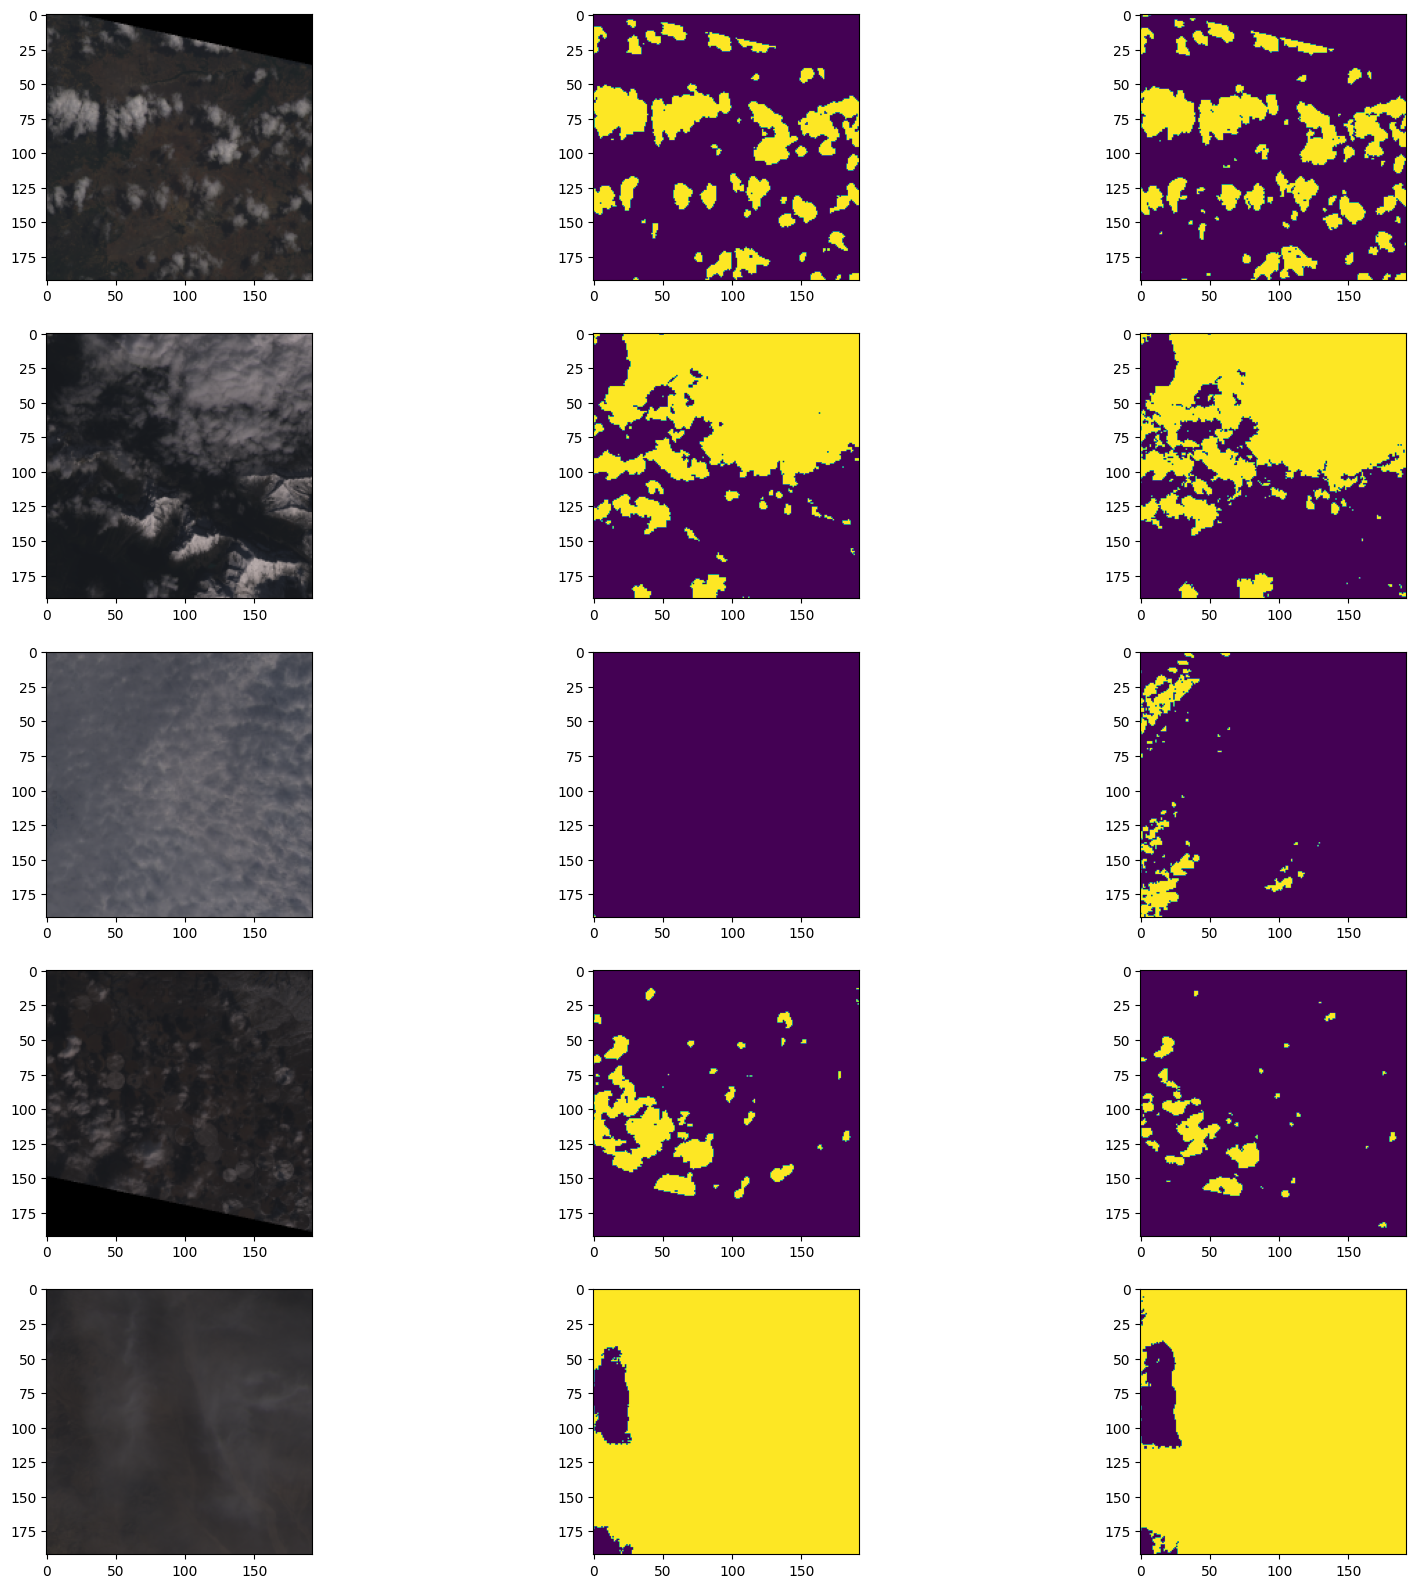

In [17]:
cnt = 0
rows = 5
columns = 3
fig = plt.figure(figsize=(20, 20))

for img, label in dataset.valid_dataset:
    cnt += 1
    image = np.dstack((img[0][1], img[0][2], img[0][3]))
    fig.add_subplot(rows, columns, (cnt-1)*3+1)
    plt.imshow(image)
   
    preds = model(img.cuda())
    preds = (preds > 0.5).float()
    predict = preds[0].swapaxes(0,1)
    predict = predict.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+2)
    plt.imshow(predict.cpu().detach().numpy())

    labels = label[0].swapaxes(0,1)
    labels = labels.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+3)
    plt.imshow(labels)

    if cnt == 5: break
plt.show()    